# "Cross-validation" des modèles

In [1]:
learning_rate = 0.04
num_epochs = 1000
N = 150
N_cv = 40
seed = 42
batch_size = N//4
batch_size = N//2
batch_size = N

N_test = 0
N_test = 1000
N_scan = 9

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Creer des données synthetiques 

In [3]:
def get_data(
            N = N,
            p0 = 0.10,
            theta0 = 0,
            wt = np.pi/20,
            theta_std = np.pi/4,
            seed=seed):
    np.random.seed(seed)
    theta = np.random.randn(N)*theta_std
    
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    p = p0/2 + (1-p0) * p
    
    y = np.random.rand(N) < p
    return theta, p, y


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')
criterion = torch.nn.BCELoss()

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True, logit0=-2):
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias=bias)    
        self.logit0 = torch.nn.Parameter(logit0*torch.ones(1))

    def forward(self, theta):
        #out = torch.sigmoid(self.logit0)/2 + (1-torch.sigmoid(self.logit0))*torch.sigmoid(self.linear(theta))
        out = self.logit0.sigmoid()/2 + (1-self.logit0.sigmoid())*self.linear(theta).sigmoid()
        return out

def fit_data(theta, y, 
                learning_rate =learning_rate,
                num_epochs = num_epochs,
                batch_size = batch_size,
                verbose=False):

    logistic_model = LogisticRegressionModel()

    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])

    loader = DataLoader(TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate/len(loader))
    
    for epoch in range(int(num_epochs)):
        losses = []
        for Theta_, labels_ in loader:
            optimizer.zero_grad()
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    logistic_model.eval()
    return logistic_model, np.mean(losses)

In [5]:
torch.sigmoid(torch.tensor([-3.]))

tensor([0.0474])

In [6]:
%%timeit
theta, p, y = get_data()

19.1 µs ± 120 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [7]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y, verbose=True)

Iteration: 0 - Loss: 0.58022
Iteration: 31 - Loss: 0.42548
Iteration: 62 - Loss: 0.38906
Iteration: 93 - Loss: 0.37859
Iteration: 124 - Loss: 0.37502
Iteration: 155 - Loss: 0.37371
Iteration: 186 - Loss: 0.37320
Iteration: 217 - Loss: 0.37298
Iteration: 248 - Loss: 0.37287
Iteration: 279 - Loss: 0.37280
Iteration: 310 - Loss: 0.37274
Iteration: 341 - Loss: 0.37270
Iteration: 372 - Loss: 0.37267
Iteration: 403 - Loss: 0.37264
Iteration: 434 - Loss: 0.37261
Iteration: 465 - Loss: 0.37259
Iteration: 496 - Loss: 0.37257
Iteration: 527 - Loss: 0.37256
Iteration: 558 - Loss: 0.37254
Iteration: 589 - Loss: 0.37253
Iteration: 620 - Loss: 0.37252
Iteration: 651 - Loss: 0.37251
Iteration: 682 - Loss: 0.37250
Iteration: 713 - Loss: 0.37249
Iteration: 744 - Loss: 0.37249
Iteration: 775 - Loss: 0.37248
Iteration: 806 - Loss: 0.37247
Iteration: 837 - Loss: 0.37247
Iteration: 868 - Loss: 0.37246
Iteration: 899 - Loss: 0.37246
Iteration: 930 - Loss: 0.37246
Iteration: 961 - Loss: 0.37245
Iteration: 99

In [8]:
with torch.no_grad():
    print('bias', logistic_model.linear.bias.item())
    print('slope', logistic_model.linear.weight.item())    
    print('p0', torch.sigmoid(logistic_model.logit0).item())    

bias 0.580264765287164
slope 3.9117732528092715
p0 0.0004805377570908977


loss= 0.37244695751642404


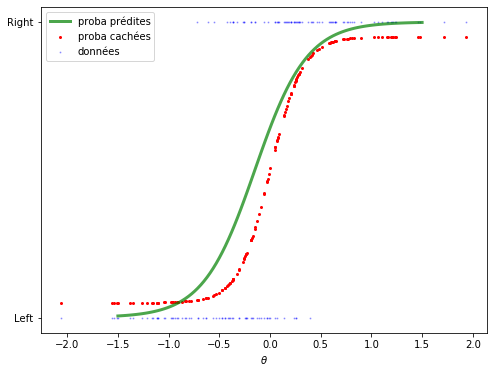

In [9]:
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.3, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();


In [10]:
%%timeit
logistic_model, loss = fit_data(theta, y, verbose=False)

1.53 s ± 8.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## validation

loss= tensor(0.3724, grad_fn=<BinaryCrossEntropyBackward>)


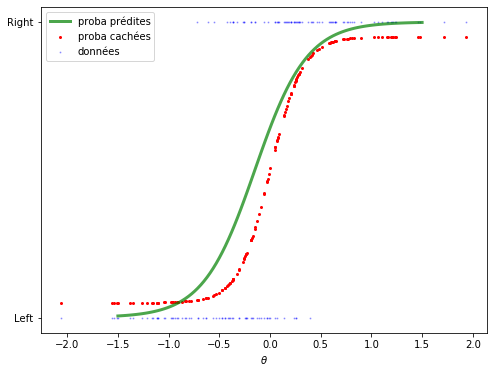

In [11]:
theta, p, y = get_data() # nouvelles données 

labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])
outputs = logistic_model(Theta)
loss = criterion(outputs, labels)
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.3, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();

## influence du nombre de trials

In [ ]:
Ns = np.logspace(1, 3, N_scan, base=10)
Ns_, losses, loss_Ps, loss_P0s = [], [], [], []
for N_ in Ns:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        P = torch.Tensor(p[:, None])
        
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
        
        loss_P = criterion(outputs, P).item() 
        loss_P0 = criterion(P, P).item()
        if i_CV==0: print(f"N: {int(N_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        loss_P0s.append(loss_P0)
        Ns_.append(N_)
        loss_Ps.append(loss_P)
        losses.append(loss)

N: 10, Loss: 0.55146, loss_P: 0.57613, loss_P0: 0.36166
N: 17, Loss: 0.38278, loss_P: 0.39468, loss_P0: 0.36166
N: 31, Loss: 0.36538, loss_P: 0.37942, loss_P0: 0.36166


In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(Ns_, losses, alpha=3/N_cv, label='loss')
ax.scatter(Ns_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(Ns_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # trials')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')

## influence du nombre du learning rate


In [ ]:
learning_rates = learning_rate * np.logspace(-1, 1, N_scan, base=10)
learning_rates_, losses, loss_Ps, loss_P0s = [], [], [], []
for learning_rate_ in learning_rates:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, learning_rate=learning_rate_, verbose=False)

        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"learning_rate: {learning_rate_:.5f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        learning_rates_.append(learning_rate_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(learning_rates_, losses, alpha=3/N_cv, label='loss')
ax.scatter(learning_rates_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(learning_rates_, loss_P0s, label='loss_P0')
ax.set_xlim(np.min(learning_rates_), np.max(learning_rates_))

ax.set_xlabel('learning_rate')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence du nombre d'epochs

In [ ]:
num_epochss = num_epochs * np.logspace(-1, 1, N_scan, base=10)
num_epochss_, losses, loss_Ps, loss_P0s = [], [], [], []
for num_epochs_ in num_epochss:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, num_epochs=int(num_epochs_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"num_epochs: {int(num_epochs_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        num_epochss_.append(num_epochs_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(num_epochss_, losses, alpha=3/N_cv, label='loss')
ax.scatter(num_epochss_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(num_epochss_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # epochss')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence de la taille du minibatch

In [ ]:
batch_sizes = N * np.logspace(-3, 0, N_scan, base=2)
batch_sizes_, losses, loss_Ps, loss_P0s = [], [], [], []
for batch_size_ in batch_sizes:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, batch_size=int(batch_size_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"batch_size: {int(batch_size_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        batch_sizes_.append(batch_size_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(batch_sizes_, losses, alpha=3/N_cv, label='loss')
ax.scatter(batch_sizes_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(batch_sizes_, loss_P0s, label='loss_P0')

ax.set_xlabel(' batch_size')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');